# Scrapping Luis Saavedra Carretero
Este proyecto tiene como finalidad la extracción de data requerida desde la página http://books.toscrape.com/ En la cual se nos solicitó extraer:
* 1) el título de los libros
* 2) Precio
* 3) Stock 
* 4) Categoría
* 5) Carátula del libro (url)
* 6) Descripción del libro (
    UPC
    Product Type
    Price (excl. tax)
    Price (incl. tax)
    Tax
    Availability
    Number of reviews
)
<br> <br>
Por lo que lo haremos con las siguientes librerías: BeautifulSoup4, requests y regex. <br> <br> <br>
Una vez extraída la data, debemos almacenar todos estos datos en un archivo csv; para ello, usaremos la librería pandas para crear un dataFrame y así guardarlo en formato csv

In [11]:
conda install -c conda-forge pipreqs

Solving environment: \ 
  - anaconda/osx-64::ca-certificates-2020.10.14-0, anaconda/osx-64::openssl-1.1.1h-haf1e3a3_0
  - anaconda/osx-64::ca-certificates-2020.10.14-0, defaults/osx-64::openssl-1.1.1h-haf1e3a3_0
  - anaconda/osx-64::openssl-1.1.1h-haf1e3a3_0, defaults/osx-64::ca-certificates-2020.10.14-0
  - defaults/osx-64::ca-certificates-2020.10.14-0, defaults/osx-64::openssl-1.1.1h-haf1e3a3done

## Package Plan ##

  environment location: /Users/lasc/opt/anaconda3

  added / updated specs:
    - pipreqs


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    docopt-0.6.2               |             py_1          14 KB  conda-forge
    pipreqs-0.4.10             |             py_0          27 KB  conda-forge
    yarg-0.1.9                 |             py_1          13 KB  conda-forge
    ------------------------------------------------------------
                                          

Importamos librerías que vamos a utilizar a lo largo de este proyecto

In [1]:
import pandas as pd 
from bs4 import BeautifulSoup as bs 
import requests as rq 
import re

## 1) Obtener contenido de la página principal
En esta sección lo que haremos, será crear la variable que contendrá la página principal, donde se encuentran todas las categorías, libros, etc. 

In [2]:
#recorrer y obtener títulos de libros
main_url = 'http://books.toscrape.com/index.html' #página principal
page = rq.get(main_url) #obtenemos el requests de la página
soup = bs(page.text, 'html.parser') #usamos beautiful soup para leer nuestro html

## 1.1) Creando función getAndParseURL() para obtener todas las páginas en formato óptimo para BeautifulSoup
Como podemos percatarnos, tendremos que navegar por muchas páginas durante este proyecto para obtener todos los libros, así que crearemos una función que nos permitirá obtener cualquier página del sitio y leerlo mediante BeautifulSoup.

In [3]:
#creamos función para obtener cualquier página
def getAndParseURL(url):
    """
    Función que tiene como objetivo obtener/parsear cualquier 
    página, mediante su url
    """
    result = rq.get(url)
    soup = bs(result.text, 'html.parser')
    return(soup)

## 2) Obtener los libros de una determinada url (sección de prueba)
Una vez ya adentrado en nuestra página, debemos obtener la información de cada libro en la página que sea. En este caso, vemos que el libro se encuentra dentro de un "article" (de html) y con la clase "product_pod".
Haremos la prueba de obtener solamente el primer producto que encuentre con las características/atributos mencionados anteriormente

In [4]:
soup.find("article", class_ = "product_pod")

<article class="product_pod">
<div class="image_container">
<a href="catalogue/a-light-in-the-attic_1000/index.html"><img alt="A Light in the Attic" class="thumbnail" src="media/cache/2c/da/2cdad67c44b002e7ead0cc35693c0e8b.jpg"/></a>
</div>
<p class="star-rating Three">
<i class="icon-star"></i>
<i class="icon-star"></i>
<i class="icon-star"></i>
<i class="icon-star"></i>
<i class="icon-star"></i>
</p>
<h3><a href="catalogue/a-light-in-the-attic_1000/index.html" title="A Light in the Attic">A Light in the ...</a></h3>
<div class="product_price">
<p class="price_color">Â£51.77</p>
<p class="instock availability">
<i class="icon-ok"></i>
    
        In stock
    
</p>
<form>
<button class="btn btn-primary btn-block" data-loading-text="Adding..." type="submit">Add to basket</button>
</form>
</div>
</article>

#### Ahora podemos obtener la url del libro para así acceder y tomar sus atributos. 
En este caso haremos una prueba con el primer producto. Ahora vamos a utilizar una función para obtener todas las urls de los libros

In [5]:
soup.find("article", class_ = "product_pod").div.a.get('href')

'catalogue/a-light-in-the-attic_1000/index.html'

Lo que haremos será almacenar en una lista todos los href, para ello utilizaremos lo que se conoce como "List Comprehension"

In [6]:
main_books_urls = [x.div.a.get('href') for x in soup.findAll("article", class_ = 'product_pod')]
main_books_urls[:10] #consultaremos los primeros 10 urls

['catalogue/a-light-in-the-attic_1000/index.html',
 'catalogue/tipping-the-velvet_999/index.html',
 'catalogue/soumission_998/index.html',
 'catalogue/sharp-objects_997/index.html',
 'catalogue/sapiens-a-brief-history-of-humankind_996/index.html',
 'catalogue/the-requiem-red_995/index.html',
 'catalogue/the-dirty-little-secrets-of-getting-your-dream-job_994/index.html',
 'catalogue/the-coming-woman-a-novel-based-on-the-life-of-the-infamous-feminist-victoria-woodhull_993/index.html',
 'catalogue/the-boys-in-the-boat-nine-americans-and-their-epic-quest-for-gold-at-the-1936-berlin-olympics_992/index.html',
 'catalogue/the-black-maria_991/index.html']

#### Ahora crearemos una función para obtener la información de cualquier libro desde cualquier página (ya que no solo trabajaremos con la página principal)

In [7]:
def obtenerLibroUrls(url):
    """
    Función para obtener libros desde cualquier página 
    (de bookstoscrape).
    """
    soup = getAndParseURL(url)
    return(["/".join(url.split("/")[:-1]) + "/" + x.div.a.get('href') for x in soup.findAll("article", class_ = "product_pod")])

## 3) Obteniendo las urls de cada categoría
Obtendremos las categorías de los libros (url). En esta ocasión, utilizaremos una herramienta que nos será de mucha utilidad, **Regex**, el cual buscaremos un patrón dentro del href que direcciona a las categorías, que en este caso es: **catalogue/category/books/nombre_categoría**

In [8]:
#obtenemos categorías
categorias_url = [main_url.replace('index.html','') + x.get('href') for x in soup.find_all('a', href = re.compile('catalogue/category/books'))]
categorias_url[:5]#consultamos

['http://books.toscrape.com/catalogue/category/books_1/index.html',
 'http://books.toscrape.com/catalogue/category/books/travel_2/index.html',
 'http://books.toscrape.com/catalogue/category/books/mystery_3/index.html',
 'http://books.toscrape.com/catalogue/category/books/historical-fiction_4/index.html',
 'http://books.toscrape.com/catalogue/category/books/sequential-art_5/index.html']

Nos percatamos que poseemos las urls de todas las categorías, es cosa de copiar una y la pegamos en nuestro navegador para ver que funciona. En el primer elemento, vemos que es el index.html de todos los libros, así que vamos a eliminarlo

In [9]:
categorias_url = categorias_url[1:]
#quitamos http://books.toscrape.com/catalogue/category/books_1/index.html

In [56]:
len(categorias_url) #podemos contar las categorías y obtenemos 50 urls

50

## 4) Obteniendo el número de páginas 
Nos hemos percatado que no solo existe una página, sino pueden existir varias (además pueden agregarse durante el tiempo), así que vamos obtener el número de las páginas con la siguiente serie de pasos

In [11]:
paginas_url = [main_url] #creamos una variable donde tendremos nuestras url de las paginas (todas***)

In [12]:
paginas_url #consultamos su contenido

['http://books.toscrape.com/index.html']

In [16]:
paginas_url
soup = getAndParseURL(paginas_url[0])
type(soup)

bs4.BeautifulSoup

In [75]:
soup = getAndParseURL(paginas_url[0])#utilizamos nuestra página para leer las demás páginas. 
#a continuacion vamos a revisar si contiene algún botón que nos lleve a la otra página
while len(soup.findAll('a', href = re.compile('page'))) == 2 or len(paginas_url) == 1:
    new_url = "/".join(paginas_url[-1].split('/')[:-1]) + "/" + soup.findAll('a', href = re.compile('page'))[-1].get('href')
    paginas_url.append(new_url)
    soup = getAndParseURL(new_url)

In [78]:
len(paginas_url) #vemos cuantas páginas en total hemos coleccionado

50

In [17]:
paginas_url[-1]#obtenemos la última y la consultamos

'http://books.toscrape.com/index.html'

## 5) Obtener la url de todos los libros en cualquier página.
Aquí utilizaremos la funcion de obtenerlibrourls, la cual obtiene los libros según una url entregada. En este caso tenemos 50 urls, y obtendremos todos los libros de esas urls

In [18]:
libros_url = []

for page in paginas_url:
    libros_url.extend(obtenerLibroUrls(page)) #extendemos desde un iterable como es la obtencion de las urls de los libros

In [22]:
paginas_url[0]

'http://books.toscrape.com/index.html'

In [23]:
libros_url[0]

'http://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html'

In [86]:
libros_url[:10] #consultamos los primeros 10 libros y los podemos copiar en nuestro navegador para comprobar

['http://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html',
 'http://books.toscrape.com/catalogue/tipping-the-velvet_999/index.html',
 'http://books.toscrape.com/catalogue/soumission_998/index.html',
 'http://books.toscrape.com/catalogue/sharp-objects_997/index.html',
 'http://books.toscrape.com/catalogue/sapiens-a-brief-history-of-humankind_996/index.html',
 'http://books.toscrape.com/catalogue/the-requiem-red_995/index.html',
 'http://books.toscrape.com/catalogue/the-dirty-little-secrets-of-getting-your-dream-job_994/index.html',
 'http://books.toscrape.com/catalogue/the-coming-woman-a-novel-based-on-the-life-of-the-infamous-feminist-victoria-woodhull_993/index.html',
 'http://books.toscrape.com/catalogue/the-boys-in-the-boat-nine-americans-and-their-epic-quest-for-gold-at-the-1936-berlin-olympics_992/index.html',
 'http://books.toscrape.com/catalogue/the-black-maria_991/index.html']

In [87]:
len(libros_url)#tenemos un total de 1000 libros

1000

## 6) Obteniendo los datos solicitados de los libros
Ya estando con todas las urls de los libros, vamos a proceder a obtener la información de ellos. como todos las páginas poseen la misma estructura, será más amable la obtención de los datos

In [185]:
names = []
prices = []
stock = []
img_urls = []
categories = [] 
ratings = []
upc = []
type_of = []
price_without_tax = []
price_with_tax = []
tax = []
no_reviews = []
avl = []
#vamos a obtener toda la data de los libros
for url in libros_url:
    soup = getAndParseURL(url)
    #el nombre del producto
    names.append(soup.find('div', class_ = re.compile('product_main')).h1.text)
    #el precio del producto
    #prices.append(soup.find('p', class_ = 'prices_color').text[2:])
    #stock del producto
    stock.append(re.sub('[^0-9]', '', soup.find('p', class_ = 'instock availability').text))
    #img_urls
    img_urls.append(url.replace('index.html', '') + soup.find('img').get('src'))
    #categoría
    categories.append(soup.find('a', href = re.compile('../category/books/')).get('href').split('/')[3])
    #ratings 
    ratings.append(soup.find('p', class_ = re.compile('star-rating')).get('class')[1])
    #upc
    upc.append(soup.find('table').find('tr').find('td').text)
    #tipo del producto
    type_of.append(soup.find("th", text="Product Type").find_next_sibling("td").text)
    #precio sin impuesto
    price_without_tax.append(soup.find("th", text="Price (excl. tax)").find_next_sibling("td").text[1:])
    #precio con impuesto
    price_with_tax.append(soup.find("th", text="Price (incl. tax)").find_next_sibling("td").text[1:])
    #impuesto
    tax.append(soup.find("th", text="Tax").find_next_sibling("td").text[1:])
    #reviews
    no_reviews.append(soup.find("th", text="Number of reviews").find_next_sibling("td").text)
    #disponibles
    avl.append(soup.find('p', {'class': 'availability'}).getText().replace('\n', '').strip()[10:12] + ' available')#un poco de manejo de strings

Vamos a verificar que todos poseen sus nombres y demás atributos

In [190]:
len(libros_url), len(names), len(stock), len(img_urls), len(categories), len(ratings), len(upc), len(type_of), len(price_with_tax), len(price_without_tax), len(tax), len(no_reviews)

(1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000)

## 7) Almacenando valores en un dataframe y exportando a CSV
Una vez obtenidas las listas con los valores que solicitaron en github, podemos crear nuestro dataframe con el formato adecuado que nos solicitaron. Como sabemos, los df se construyen a partir de diccionarios, así que usaremos las llaves (keys) para el nombre de cada columna y las series/listas para rellenar las filas. 

In [259]:
df = pd.DataFrame({'Title': names, 'Price': price_with_tax, 'Stock': stock, "Category": categories, 
                             "Cover": img_urls, "UPC": upc, "Product Type": type_of, "Price (excl. tax)": price_without_tax,
                             "Price (incl. tax)" : price_with_tax, "Tax" : tax, "Availability" : avl, "Number of reviews" : no_reviews 
                            })
df.head()

,Title,Price,Stock,Category,Cover,UPC,Product Type,Price (excl. tax),Price (incl. tax),Tax,Availability,Number of reviews
0,A Light in the Attic,£51.77,22,poetry_23,http://books.toscrape.com/catalogue/a-light-in...,a897fe39b1053632,Books,£51.77,£51.77,£0.00,22available,0
1,Tipping the Velvet,£53.74,20,historical-fiction_4,http://books.toscrape.com/catalogue/tipping-th...,90fa61229261140a,Books,£53.74,£53.74,£0.00,20available,0
2,Soumission,£50.10,20,fiction_10,http://books.toscrape.com/catalogue/soumission...,6957f44c3847a760,Books,£50.10,£50.10,£0.00,20available,0
3,Sharp Objects,£47.82,20,mystery_3,http://books.toscrape.com/catalogue/sharp-obje...,e00eb4fd7b871a48,Books,£47.82,£47.82,£0.00,20available,0
4,Sapiens: A Brief History of Humankind,£54.23,20,history_32,http://books.toscrape.com/catalogue/sapiens-a-...,4165285e1663650f,Books,£54.23,£54.23,£0.00,20available,0


## 7.1) Un poco de manejo de datos en dataframes 
Podemos percatarnos que en categorías hay un problema con el nombre de esta (ejemplo mystery_32), vamos a arreglarlo

In [269]:
l = []
for i in df['Category']:
    l.append(i.split('_')[0])
df['Category'] = l

In [270]:
df.head()

,Title,Price,Stock,Category,Cover,UPC,Product Type,Price (excl. tax),Price (incl. tax),Tax,Availability,Number of reviews
0,A Light in the Attic,£51.77,22,poetry,http://books.toscrape.com/catalogue/a-light-in...,a897fe39b1053632,Books,£51.77,£51.77,£0.00,22available,0
1,Tipping the Velvet,£53.74,20,historical-fiction,http://books.toscrape.com/catalogue/tipping-th...,90fa61229261140a,Books,£53.74,£53.74,£0.00,20available,0
2,Soumission,£50.10,20,fiction,http://books.toscrape.com/catalogue/soumission...,6957f44c3847a760,Books,£50.10,£50.10,£0.00,20available,0
3,Sharp Objects,£47.82,20,mystery,http://books.toscrape.com/catalogue/sharp-obje...,e00eb4fd7b871a48,Books,£47.82,£47.82,£0.00,20available,0
4,Sapiens: A Brief History of Humankind,£54.23,20,history,http://books.toscrape.com/catalogue/sapiens-a-...,4165285e1663650f,Books,£54.23,£54.23,£0.00,20available,0


## 8) Exportando a CSV 
finalmente con nuestro dataFrame creado con el formato requerido, vamos a exportarlo como csv para futuros análisis

In [272]:
df.to_csv('encargo_scrapping_books_Luis_Saavedra_Carretero.csv', index = False)

## 9) creando txt con requerimientos para este proyecto
Al estar utilizando Anaconda, utilizo este comando para crear automáticamente los requerimientos

In [ ]:
conda list -e > requirements.txt

## 10) Conclusiones
<br> 
Ya finalizada esta entrega podemos afirmar que la tarea de web Scrapping es crucial para obtener información relevante. Claramente siempre teniendo ética y respetando las políticas de seguridad (siempre consultando al robot.txt) y además utilizar siempre para fines de mejorar la calidad de los servicios y no para destruir sistemas, etc. 

# Apartado Análisis de datos
El objetivo de este apartado, es generar un pequeño analisis de los datos que hemos generado a partir del scrapping. Para ello, vamos a leer el mismo csv que generamos

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [52]:
#importamos nuestro csv 
df = pd.read_csv('proyecto_script/encargo_scrapping_books_Luis_Saavedra_Carretero.csv')

In [53]:
df.head(5)#consultamos nuestros datos

,Title,Price,Stock,Category,Cover,UPC,Product Type,Price (excl. tax),Price (incl. tax),Tax,Availability,Number of reviews
0,A Light in the Attic,£51.77,22,poetry,http://books.toscrape.com/catalogue/a-light-in...,a897fe39b1053632,Books,£51.77,£51.77,£0.00,22 available,0
1,Tipping the Velvet,£53.74,20,historical-fiction,http://books.toscrape.com/catalogue/tipping-th...,90fa61229261140a,Books,£53.74,£53.74,£0.00,20 available,0
2,Soumission,£50.10,20,fiction,http://books.toscrape.com/catalogue/soumission...,6957f44c3847a760,Books,£50.10,£50.10,£0.00,20 available,0
3,Sharp Objects,£47.82,20,mystery,http://books.toscrape.com/catalogue/sharp-obje...,e00eb4fd7b871a48,Books,£47.82,£47.82,£0.00,20 available,0
4,Sapiens: A Brief History of Humankind,£54.23,20,history,http://books.toscrape.com/catalogue/sapiens-a-...,4165285e1663650f,Books,£54.23,£54.23,£0.00,20 available,0


In [54]:
df.describe()#obtenemos un resumen estadístico rápido con pandas de nuestro dataFrame

,Stock,Number of reviews
count,1000.000000,1000.0
mean,8.585000,0.0
std,5.654622,0.0
min,1.000000,0.0
25%,3.000000,0.0
50%,7.000000,0.0
75%,14.000000,0.0
max,22.000000,0.0


In [55]:
df.dtypes

Title                object
Price                object
Stock                 int64
Category             object
Cover                object
UPC                  object
Product Type         object
Price (excl. tax)    object
Price (incl. tax)    object
Tax                  object
Availability         object
Number of reviews     int64
dtype: object

Podemos observar que nuestros datos relacionado a precios están en formato string/objeto por el hecho de poseer el signo euro (€), así que vamos a convertir esa data (temporalmente) a flotantes y así trabajar de mejor manera. En este caso solo vamos a usar la variable "precio" el cual contiene el precio junto a su impuesto

In [57]:
#hacemos pruebas
df.Price = df.Price.str.replace('£', '', regex = True)#removemos el signo euro
df.Price = df.Price.astype(float)#convertimos a flotante

In [58]:
#volvemos a realizar la consulta estadística para ver si toma ahora la variable
df.describe()

,Price,Stock,Number of reviews
count,1000.00000,1000.000000,1000.0
mean,35.07035,8.585000,0.0
std,14.44669,5.654622,0.0
min,10.00000,1.000000,0.0
25%,22.10750,3.000000,0.0
50%,35.98000,7.000000,0.0
75%,47.45750,14.000000,0.0
max,59.99000,22.000000,0.0


## Consultando por las categorías 

### Categorías con más stock en la tienda

In [59]:
df.head()#para ver las columnas

,Title,Price,Stock,Category,Cover,UPC,Product Type,Price (excl. tax),Price (incl. tax),Tax,Availability,Number of reviews
0,A Light in the Attic,51.77,22,poetry,http://books.toscrape.com/catalogue/a-light-in...,a897fe39b1053632,Books,£51.77,£51.77,£0.00,22 available,0
1,Tipping the Velvet,53.74,20,historical-fiction,http://books.toscrape.com/catalogue/tipping-th...,90fa61229261140a,Books,£53.74,£53.74,£0.00,20 available,0
2,Soumission,50.10,20,fiction,http://books.toscrape.com/catalogue/soumission...,6957f44c3847a760,Books,£50.10,£50.10,£0.00,20 available,0
3,Sharp Objects,47.82,20,mystery,http://books.toscrape.com/catalogue/sharp-obje...,e00eb4fd7b871a48,Books,£47.82,£47.82,£0.00,20 available,0
4,Sapiens: A Brief History of Humankind,54.23,20,history,http://books.toscrape.com/catalogue/sapiens-a-...,4165285e1663650f,Books,£54.23,£54.23,£0.00,20 available,0


In [103]:
np.unique(df.Category)#vemos que tenemos las 50 categorías. podemos ver las categorías únicas

array(['academic', 'add-a-comment', 'adult-fiction', 'art',
       'autobiography', 'biography', 'business', 'childrens', 'christian',
       'christian-fiction', 'classics', 'contemporary', 'crime',
       'cultural', 'default', 'erotica', 'fantasy', 'fiction',
       'food-and-drink', 'health', 'historical', 'historical-fiction',
       'history', 'horror', 'humor', 'music', 'mystery', 'new-adult',
       'nonfiction', 'novels', 'paranormal', 'parenting', 'philosophy',
       'poetry', 'politics', 'psychology', 'religion', 'romance',
       'science', 'science-fiction', 'self-help', 'sequential-art',
       'short-stories', 'spirituality', 'sports-and-games', 'suspense',
       'thriller', 'travel', 'womens-fiction', 'young-adult'],
      dtype=object)

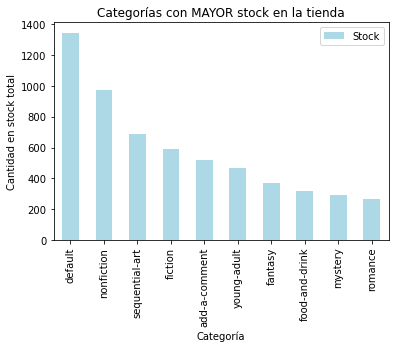

In [102]:
df.groupby('Category')['Stock'].sum().sort_values(ascending = False).reset_index()[:10].plot(kind = 'bar' ,x = 'Category', color = 'lightblue')
plt.xlabel('Categoría')
plt.ylabel('Cantidad en stock total')
plt.title('Categorías con MAYOR stock en la tienda');

Podemos observar en esta gráfica las 10 categorías con mayor stock en la tienda. 

## Categorías con menor stock

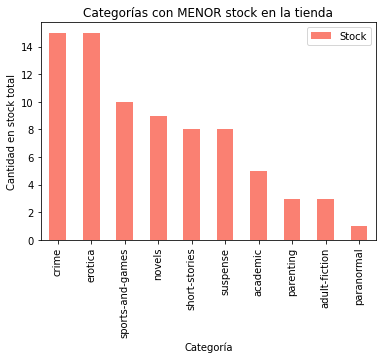

In [101]:
df.groupby('Category')['Stock'].sum().sort_values(ascending = False).reset_index()[len(df.groupby('Category')['Stock'].sum().sort_values(ascending = False).reset_index()) - 10:].plot(kind = 'bar' ,x = 'Category', color = 'salmon')
plt.xlabel('Categoría')
plt.ylabel('Cantidad en stock total')
plt.title('Categorías con MENOR stock en la tienda');

## Consultas relacionadas al precio 

In [104]:
df.head()

,Title,Price,Stock,Category,Cover,UPC,Product Type,Price (excl. tax),Price (incl. tax),Tax,Availability,Number of reviews
0,A Light in the Attic,51.77,22,poetry,http://books.toscrape.com/catalogue/a-light-in...,a897fe39b1053632,Books,£51.77,£51.77,£0.00,22 available,0
1,Tipping the Velvet,53.74,20,historical-fiction,http://books.toscrape.com/catalogue/tipping-th...,90fa61229261140a,Books,£53.74,£53.74,£0.00,20 available,0
2,Soumission,50.10,20,fiction,http://books.toscrape.com/catalogue/soumission...,6957f44c3847a760,Books,£50.10,£50.10,£0.00,20 available,0
3,Sharp Objects,47.82,20,mystery,http://books.toscrape.com/catalogue/sharp-obje...,e00eb4fd7b871a48,Books,£47.82,£47.82,£0.00,20 available,0
4,Sapiens: A Brief History of Humankind,54.23,20,history,http://books.toscrape.com/catalogue/sapiens-a-...,4165285e1663650f,Books,£54.23,£54.23,£0.00,20 available,0


### Las categorías más caras en vitrina

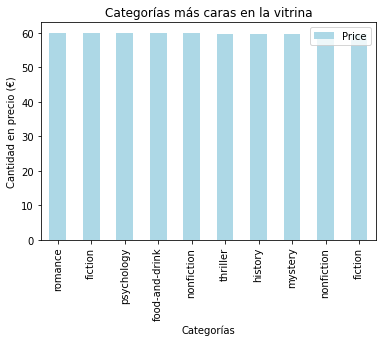

In [141]:
df.sort_values(by = 'Price', ascending = False)[['Title', 'Price', 'Category']][:10].plot(kind = 'bar', x = 'Category', color = 'lightblue' )
plt.xlabel('Categorías')
plt.ylabel('Cantidad en precio (€)')
plt.title('Categorías más caras en la vitrina');

Podemos observar que los 10 libros más caros pertenecen a romance, ficción, psicología. Podemos ver sus nombres así

In [146]:
df.sort_values(by = 'Price', ascending = False)[['Title', 'Category']][:10]

,Title,Category
648,The Perfect Play (Play by Play #1),romance
617,Last One Home (New Beginnings #1),fiction
860,Civilization and Its Discontents,psychology
560,The Barefoot Contessa Cookbook,food-and-drink
366,The Diary of a Young Girl,nonfiction
657,The Bone Hunters (Lexy Vaughan & Steven Macaul...,thriller
133,Thomas Jefferson and the Tripoli Pirates: The ...,history
387,Boar Island (Anna Pigeon #19),mystery
549,The Man Who Mistook His Wife for a Hat and Oth...,nonfiction
393,The Improbability of Love,fiction


### las categorías más baratitas

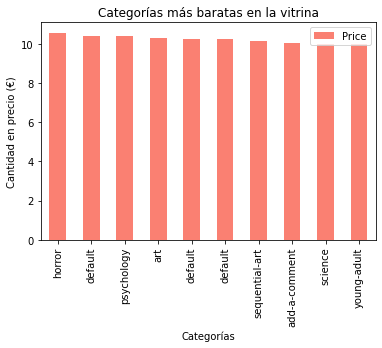

In [147]:
df.sort_values(by = 'Price', ascending = False)[['Title', 'Price', 'Category']][len(df) - 10:].plot(kind = 'bar', x = 'Category', color = 'salmon');
plt.xlabel('Categorías')
plt.ylabel('Cantidad en precio (€)')
plt.title('Categorías más baratas en la vitrina');

Acá podemos ver todo lo contario, gran mayoría de los libros más barato no pertenecen a categorías "caras" (salvo psicología). Podemos ver sus nombres aquí

In [150]:
df.sort_values(by = 'Price', ascending = False)[['Title', 'Category']][len(df) - 10:]

,Title,Category
274,Pet Sematary,horror
434,"NaNo What Now? Finding your editing process, r...",default
242,The Lucifer Effect: Understanding How Good Peo...,psychology
479,History of Beauty,art
558,The Fellowship of the Ring (The Lord of the Ri...,default
302,Greek Mythic History,default
84,Patience,sequential-art
716,The Tipping Point: How Little Things Can Make ...,add-a-comment
501,The Origin of Species,science
638,An Abundance of Katherines,young-adult
